# Лабораторная работа "Краевая задача для ОДУ 2 порядка"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import threading as thr
from ipywidgets import interact, widgets, interactive

class GridFunction:
    def __init__(self, a, b, h, dim=1):
        self.dim = dim
        self.n = int((b - a) / h) + 1

        self.a = a
        self.b = a + h * (self.n - 1)
        self.h = h

        self.x = np.zeros(self.n)
        for i in range(self.n):
            self.x[i] = a + self.h * i

        if self.dim == 0:
            self.y = [[0]] * self.n
        elif self.dim == 1:
            self.y = np.zeros(self.n)
        else:
            np_list = []
            for i in range(self.n):
                np_list.append(np.zeros(self.dim))
            self.y = np.asarray(np_list)

    def calc(self, func, thread=False):
        self.f = func

        if thread:
            def thread_calc(i):
                self.y[i] = func(self.x[i])

            threads = [
                thr.Thread(target=thread_calc, args=(i,))
                for i in range(self.x.size)
            ]
            for thread in threads:
                thread.start()
            for thread in threads:
                thread.join()
        else:
            for i in range(self.x.size):
                self.y[i] = func(self.x[i])

    def calc_diff_eq(self, x0, dx, method):
        self.y[0] = x0
        method(self, dx)

    def plot(self, axes='01', marker='', label='', title_str='', figsize=(9, 6), new=True, ext_plt='', external=False):
        if new and not external:
            fig, self.ax = plt.subplots(figsize=figsize)
            self.ax.set(xlabel='x', ylabel='y', title=title_str)
            self.ax.grid()

        if external:
            self.ax = ext_plt

        if self.dim == 0:
            x = []
            y = []
            for i in range(self.n):
                for j in range(len(self.y[i])):
                    x.append(self.x[i])
                    y.append(self.y[i][j])

            if label == '':
                self.ax.scatter(x, y, s=0.3)
            else:
                self.ax.scatter(x, y, s=0.3, label=label)
                self.ax.legend()
        else:
            x = self.x
            if axes[0] != '0':
                x = self.y
                if self.dim != 1:
                    x = np.split(self.y, self.dim, 1)[int(axes[0]) - 1]

            y = self.x
            if axes[1] != '0':
                y = self.y
                if self.dim != 1:
                    y = np.split(self.y, self.dim, 1)[int(axes[1]) - 1]

            if label == '':
                self.ax.plot(x, y, marker)
            else:
                self.ax.plot(x, y, marker, label = label)
                self.ax.legend()

def get_diff_coef(d, l, r): # f'(x_i) = sum k from -l to r (c_lr / h * f(x_i + k * h))
    n = l + r + 1
    A = np.zeros((n, n))
    f = np.zeros((n, 1))
    for i in range(n):
        for j in range(n):
            A[i][j] = (-l + j) ** i

    f[d] = 1 / m.factorial(d)
    return np.linalg.solve(A, f)

class LogError(GridFunction):
    def __init__(self, begin_h, end_h, step_h, true_x, dx):
        super().__init__(begin_h, end_h, step_h)
        self.dx = dx
        self.true_x = true_x

    def plot(self, title_str = ''):
        super().plot(title_str = title_str)
        self.ax.set(xlabel='ln(h)', ylabel='ln(Err)')
        k, b = np.polyfit(self.x, self.y, 1)

        label_str = '{:.2f}*x + {:.2f}'.format(k, b)
        self.ax.plot(self.x, k * self.x + b, 'r-', linewidth=0.5, label=label_str)
        self.ax.legend()

    def calc(self, a, b, x0, method, logarithm = False, dim = 1, get_sol = None):
        for i in range(self.n):
            def default_solution():
                gs = GridFunction(a, b, self.x[i], dim)
                gs.calc_diff_eq(x0, self.dx, method)
                return gs

            grid_sol = default_solution() if get_sol is None else get_sol(self.x[i], method)

            grid_true = GridFunction(a, b, self.x[i], dim)
            grid_true.calc(self.true_x)

            self.y[i] = np.amax(np.absolute(grid_sol.y - grid_true.y))

            if logarithm:
                self.x[i] = m.log(self.x[i])
                self.y[i] = m.log(self.y[i])

def explicit_euler(gf, f):
    for i in range(1, gf.n):
        gf.y[i] = gf.y[i - 1] + gf.h * f(gf.y[i - 1], gf.x[i - 1])

def runge_kutta_2(gf, f):
    for i in range(1, gf.n):
        gf.y[i] = gf.y[i - 1] + gf.h * f(gf.y[i - 1] + gf.h / 2 * f(gf.y[i - 1], gf.x[i - 1]), gf.x[i - 1] + gf.h / 2)

def runge_kutta_4(gf, f):
    for i in range(1, gf.n):
        k1 = f(gf.y[i - 1], gf.x[i - 1])
        k2 = f(gf.y[i - 1] + gf.h * k1 / 2, gf.x[i - 1] + gf.h / 2)
        k3 = f(gf.y[i - 1] + gf.h * k2 / 2, gf.x[i - 1] + gf.h / 2)
        k4 = f(gf.y[i - 1] + gf.h * k3, gf.x[i - 1] + gf.h)
        gf.y[i] = gf.y[i - 1] + gf.h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def tridiagonal(a, b, c, d):
    nf = len(d)
    for it in range(1, nf):
        mc = a[it] / b[it - 1]
        b[it] = b[it] - mc * c[it - 1]
        d[it] = d[it] - mc * d[it - 1]

    x = b
    x[-1] = d[-1] / b[-1]
    for il in range(nf - 2, -1, -1):
        x[il] = (d[il] - c[il] * x[il + 1]) / b[il]

    return x

В качастве уравнения возьмем
$$
\begin{equation*}
    \begin{cases}
    x^2y''+xy'+y=x \\
    y(1)+y'(1)=1 \\
    y(e^\pi)=e^\pi \\
    \end{cases}
\end{equation*}
$$
на отрезке $[1, e^\pi]$. $\\$
Решение $y(x)=\frac{1}{2}(-e^\pi cos(ln(x))+e^\pi sin(ln(x))+x)$

## Метод стрельбы

In [2]:
my_dv = lambda v, x: np.array([v[1],
                               1 / x - v[1] / x - v[0] / x / x])
my_y_a = lambda z_a: 1 - z_a
my_y = lambda x: (m.exp(m.pi) * (-m.cos(m.log(x)) + m.sin(m.log(x))) + x) / 2
a = 1
b = m.exp(m.pi)
y_b = m.exp(m.pi)

def get_y(h, z_a, method):
    gv = GridFunction(a, b, h, 2)
    gv.calc_diff_eq(np.array([my_y_a(z_a), z_a]), my_dv, method)
    gv.y = np.split(gv.y, 2, 1)[0].flatten()
    return gv

def get_solution(h, method):
    z0 = (a * 2 + b) / 3
    z1 = (a + b * 2) / 3
    y0 = get_y(h, z0, method).y[-1]
    y1 = get_y(h, z1, method).y[-1]
    z_a = (y_b * (z1 - z0) + z0 * y1 - z1 * y0) / (y1 - y0)
    return get_y(h, z_a, method)

def bdu1(begin_h, end_h, step_h, method):
    logerr = LogError(begin_h, end_h, step_h, my_y, my_dv)
    logerr.calc(a, b, 0, method, True, 1, get_solution)
    logerr.plot()

#### Метод Рунге-Кутты 2 порядка

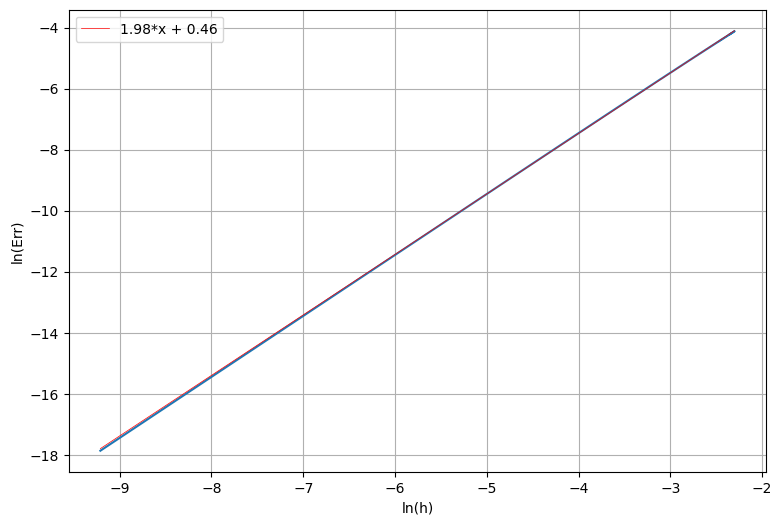

In [3]:
bdu1(0.0001, 0.1, 0.0001, runge_kutta_2)

#### Метод Рунге-Кутты 4 порядка

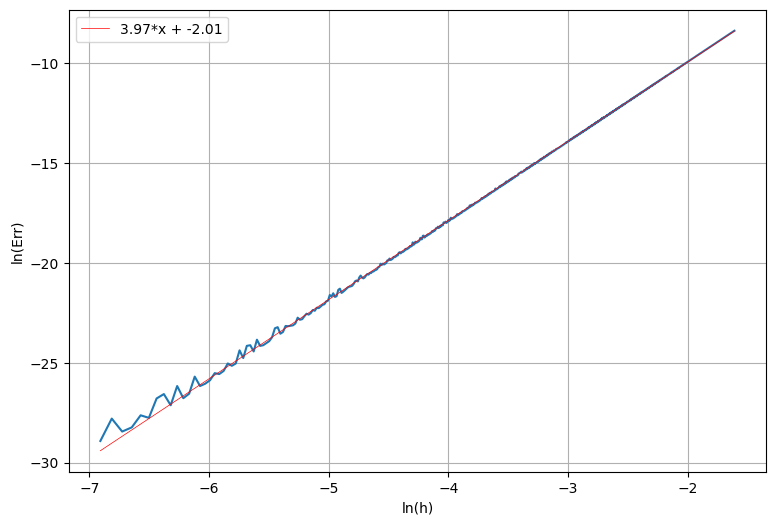

In [4]:
bdu1(0.001, 0.2, 0.0001, runge_kutta_4)

## Конечно-разностный метод

In [5]:
p = lambda x: 1 / x
q = lambda x: 1 / (x * x)
f = lambda x: 1 / x

alpha = 1
betta = 1
gamma = 1

my_y = lambda x: (m.exp(m.pi) * (-m.cos(m.log(x)) + m.sin(m.log(x))) + x) / 2

a = 1
b = m.exp(m.pi)
y_b = m.exp(m.pi)

def get_solution(h, method):
    gf = GridFunction(a, b, h)

    a_ = np.zeros(gf.n)
    b_ = np.zeros(gf.n)
    c_ = np.zeros(gf.n)
    d_ = np.zeros(gf.n)
    for i in range(1, gf.n - 1):
        a_[i] = 2 - p(gf.x[i]) * h
        b_[i] = 2 * h * h * q(gf.x[i]) - 4
        c_[i] = 2 + p(gf.x[i]) * h
        d_[i] = 2 * h * h * f(gf.x[i])

    b_[0] = alpha - 3 * betta / 2 / h - (2 - p(gf.x[1]) * h) * (-betta / 2 / h) / (2 + p(gf.x[1]) * h)
    c_[0] = 2 * betta / h - (2 * h * h * q(gf.x[1]) - 4) * (-betta / 2 / h) / (2 + p(gf.x[1]) * h)
    d_[0] = gamma - 2 * h * h * f(gf.x[1]) * (-betta / 2 / h) / (2 + p(gf.x[1]) * h)
    b_[gf.n - 1] = 1
    d_[gf.n - 1] = y_b

    gf.y = tridiagonal(a_, b_, c_, d_)
    return gf

def bdu2(begin_h, end_h, step_h):
    logerr = LogError(begin_h, end_h, step_h, my_y, None)
    logerr.calc(a, b, 0, None, True, 1, get_solution)
    logerr.plot()

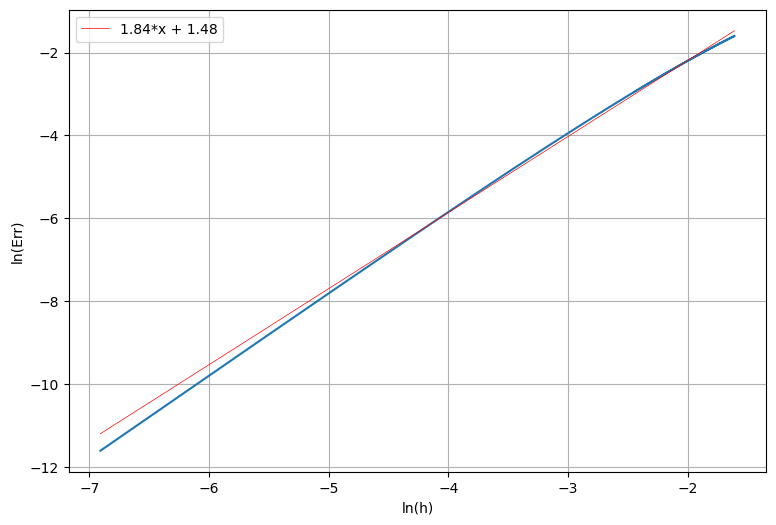

In [6]:
bdu2(0.001, 0.2, 0.0001)

## Метод фиктивной точки

In [7]:
def get_solution(h, method):
    gf = GridFunction(a, b, h)

    a_ = np.zeros(gf.n)
    b_ = np.zeros(gf.n)
    c_ = np.zeros(gf.n)
    d_ = np.zeros(gf.n)
    for i in range(1, gf.n - 1):
        a_[i] = 2 - p(gf.x[i]) * h
        b_[i] = 2 * h * h * q(gf.x[i]) - 4
        c_[i] = 2 + p(gf.x[i]) * h
        d_[i] = 2 * h * h * f(gf.x[i])

    b_[0] = 2 * h * h * q(gf.x[0]) - 4 + alpha * 2 * h * (2 - p(gf.x[0]) * h) / betta
    c_[0] = 4
    d_[0] = 2 * h * h * f(gf.x[0]) + (2 - p(gf.x[0]) * h) * gamma * 2 * h / betta
    b_[gf.n - 1] = 1
    d_[gf.n - 1] = y_b

    gf.y = tridiagonal(a_, b_, c_, d_)
    return gf

def bdu3(begin_h, end_h, step_h):
    logerr = LogError(begin_h, end_h, step_h, my_y, None)
    logerr.calc(a, b, 0, None, True, 1, get_solution)
    logerr.plot()

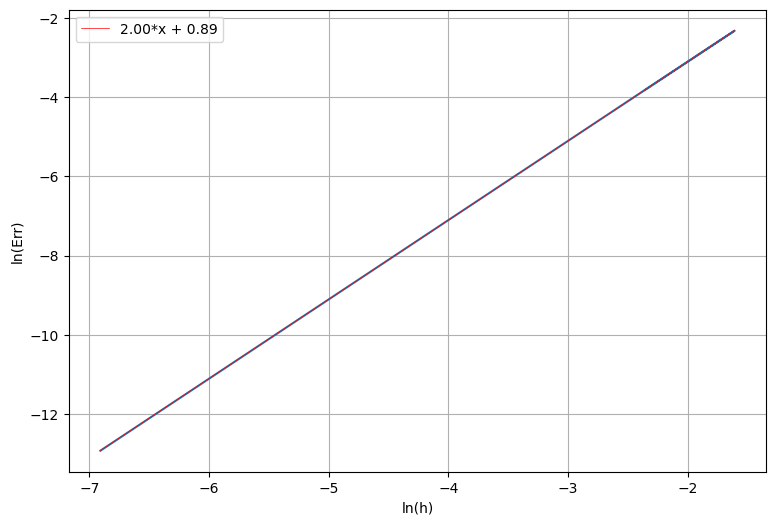

In [8]:
bdu3(0.001, 0.2, 0.0001)